In [1]:
import torch
import numpy as np
import random
from collections import deque
import import_ipynb

In [2]:
from environment import lunar_lander ,close_windows
from SACmodel import Q_critic,actor

importing Jupyter notebook from environment.ipynb
importing Jupyter notebook from SACmodel.ipynb


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
gamma=0.95
alpha=0.2
learning_rate=0.001
tau=0.005
epoch=100
replay_buffer=deque(maxlen=8192)

In [5]:
Actor=actor()
Q_critic_0=Q_critic()
Q_critic_1=Q_critic()
Q_critic_0_target=Q_critic()
Q_critic_1_target=Q_critic()

Actor.train()
Q_critic_0.train()
Q_critic_1.train()
Q_critic_0_target.train()
Q_critic_1_target.train()

optimizer_A = torch.optim.Adam(Actor.parameters(), lr=learning_rate)
optimizer_Q_0 = torch.optim.Adam(Q_critic_0.parameters(), lr=learning_rate)
optimizer_Q_1 = torch.optim.Adam(Q_critic_1.parameters(), lr=learning_rate)
Q_critic_0_target.load_state_dict(Q_critic_0.state_dict())
Q_critic_1_target.load_state_dict(Q_critic_1.state_dict())

<All keys matched successfully>

In [6]:
def soft_update(target_net, main_net, tau):
    for target_param, main_param in zip(target_net.parameters(), main_net.parameters()):
        target_param.data.copy_(tau * main_param.data + (1.0 - tau) * target_param.data)

In [7]:
def one_train():
    if len(replay_buffer)>=64:
        sampled = random.sample(replay_buffer, 64)
        
        S_0_batch=torch.stack([sample["S_0"] for sample in sampled])
        A_0_batch=torch.stack([sample["A_0"] for sample in sampled])
        R_0_batch=torch.tensor([sample["R_0"] for sample in sampled])
        S_1_batch=torch.stack([sample["S_1"] for sample in sampled])
        Done=[sample["Done"] for sample in sampled]
        Done_batch=torch.tensor([1 if D else 0 for D in Done])
        
        with torch.no_grad():
            # A(S1)
            A_1,A_1_logprob=Actor(S_1_batch)
            # Q(S1,A1)
            Q1_values_0 = Q_critic_0_target(S_1_batch, A_1)
            Q1_values_1 = Q_critic_1_target(S_1_batch, A_1)
            # min Q(S1,A1)
            min_Q_S1A1 = torch.minimum(Q1_values_0, Q1_values_1)
            y_targets = R_0_batch + gamma * (1 - Done_batch) * (min_Q_S1A1 - alpha * A_1_logprob.sum(dim=1))

        loss_Q_0=((Q_critic_0(S_0_batch,A_0_batch)-y_targets)**2).mean()
        loss_Q_1=((Q_critic_1(S_0_batch,A_0_batch)-y_targets)**2).mean()
        
        optimizer_Q_0.zero_grad()
        optimizer_Q_1.zero_grad()
        loss_Q_0.backward()
        loss_Q_1.backward()
        optimizer_Q_0.step()
        optimizer_Q_1.step()
        
        #A(S0)
        A_0,A_0_logprob=Actor(S_0_batch)
        # min Q(S0,A0)
        Q0_values_0 = Q_critic_0(S_0_batch, A_0)
        Q0_values_1 = Q_critic_1(S_0_batch, A_0)
        min_Q_S0A0 = torch.minimum(Q0_values_0, Q0_values_1)
        #loss_A
        loss_A=(min_Q_S0A0-alpha*A_0_logprob.sum(dim=1)).mean()
    
        optimizer_A.zero_grad()
        loss_A.backward()
        optimizer_A.step()
        
        soft_update(Q_critic_0_target,Q_critic_0,tau)
        soft_update(Q_critic_1_target,Q_critic_1,tau)

In [8]:
x=[]
def one_episode():
    reward=0
    time=0
    env=lunar_lander()
    env.visualize()
    Done=False
    S_0=env.state()
    S_0=torch.from_numpy(S_0)# S_0는 tensor(8)
    while not Done:
        with torch.no_grad():
            A_0,log_prob_0=Actor(S_0) #tensor(2)
        R_0,Done=env.move((A_0[0],A_0[1]))
        env.visualize()
        S_1=env.state()
        S_1 = torch.from_numpy(S_1)
        replay_buffer.append({"S_0":S_0, "A_0":A_0, "R_0":R_0,"S_1":S_1, "Done":Done})
        S_0=S_1
        reward+=R_0
        time+=1
        if time==1000:
            replay_buffer.append({"S_0":S_0, "A_0":A_0, "R_0":10,"S_1":S_1, "Done":Done})
            Done=True
            break
    x.append(reward)

In [9]:
def episode_100():
    for i in range(100):
        one_episode()
        if i%10==0:
            one_train()
    

In [10]:
for i in range(epoch):
    episode_100()
    torch.save(Actor.state_dict(), 'Actor.pth')
    torch.save(Q_critic_0.state_dict(), 'Q_critic_0.pth')
    torch.save(Q_critic_1.state_dict(), 'Q_critic_1.pth')

ValueError: Expected parameter loc (Tensor of shape (2,)) of distribution Normal(loc: torch.Size([2]), scale: torch.Size([2])) to satisfy the constraint Real(), but found invalid values:
tensor([nan, nan])

In [ ]:
import matplotlib.pyplot as plt
def visualize_scores(scores):
    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

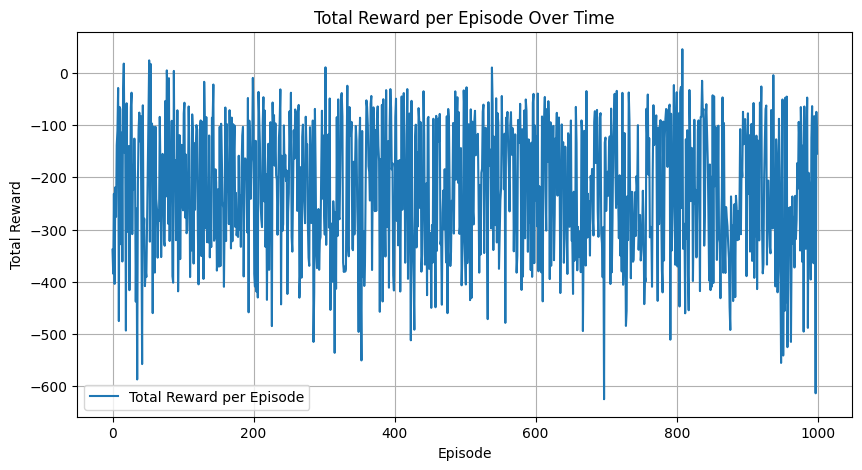

In [ ]:
visualize_scores(x)

In [ ]:
close_windows()